# Problem 4 - Regression with Shallow Nets

## Part 1 - Load and Explore the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from sklearn import preprocessing
%matplotlib inline

In [2]:
def loadMusicData(fname, addBias):
    data = pd.read_table(fname, sep = ",", header = None)
    train_years = data.iloc[:463714,0].values
    test_years = data.iloc[463714:,0].values
    if addBias:
        data[91] = 1.0
    train_feat = data.iloc[:463714,1:].values
    test_feat = data.iloc[463714:,1:].values
    return train_years, train_feat, test_years, test_feat, data

In [3]:
trainYears, trainFeat, testYears, testFeat, df = loadMusicData("music-dataset.txt", True)

In [4]:
def musicMSE(pred, gt):
    prediction = np.round(np.array(pred))
    return np.mean((gt - prediction) ** 2)

In [5]:
range_data = df.describe().loc['max'] - df.describe().loc['min']

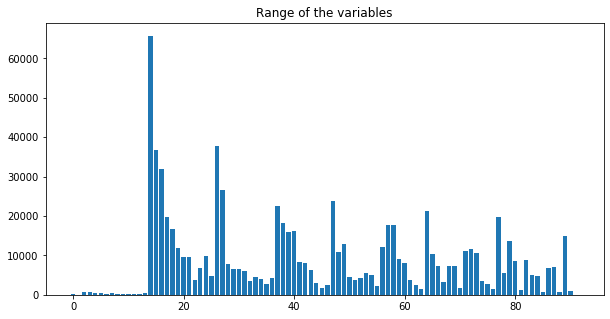

In [6]:
_ = plt.figure(figsize = (10, 5))
_ = plt.bar(np.arange(92), range_data)
_ = plt.title("Range of the variables")

In [7]:
# Function to normalize the features of the data
def normalize(train_data, test_data):
    # normalize
    mean = np.mean(train_data, axis = 0)
    mean[-1] = 0
    std = np.std(train_data, axis = 0)
    std[std == 0] = 1
    train_data_nor = (train_data - mean) / std
    test_data_nor = (test_data - mean) / std
    return train_data_nor, test_data_nor

In [8]:
trainFeat_norm, testFeat_norm = normalize(trainFeat, testFeat)

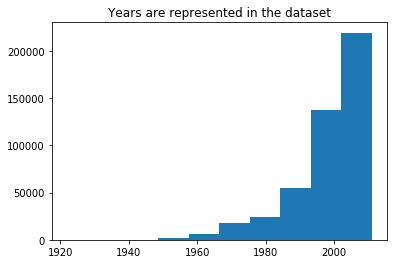

In [9]:
_ = plt.hist(trainYears)
_ = plt.title("Years are represented in the dataset")

In [10]:
y_common = np.zeros_like(testYears)
y_common = y_common + df.iloc[:, 0].mode()[0]
musicMSE(testYears, y_common)

190.08239236117836

In [11]:
y_1998 = np.zeros_like(testYears)
y_1998 = y_1998 + 1998.0
musicMSE(testYears, y_1998)

118.0090062171951

## Part 2 - Ridge Regression

In [12]:
# Forward pass function
def forward(x, weight):
    return np.dot(np.array(x), np.array(weight))

In [13]:
# Loss Function
def cal_loss(weights, data, pred, true_labels, alpha):
    # With L2 regularization
    data = np.stack(data, axis = 0)
    loss = musicMSE(pred, true_labels) + alpha * np.dot(weights.T, weights) / len(data) / 2
    loss_grad = (np.dot(data.T, (pred - true_labels)) + alpha * weights) / len(data)
    return loss, loss_grad

In [18]:
# Function to do stochastic gradient descent with mini-batches
def single_stochastic_gradient_ridge(train_data, train_labels, test_data, test_labels, weights, mini_batch_size, learning_rate, alpha):
    train_zip = list(zip(train_data, train_labels))
    shuffle(train_zip)
    train_data_shuff, train_labels_shuff = zip(*train_zip)
    
    test_zip = list(zip(test_data, test_labels))
    shuffle(test_zip)
    test_data_shuff, test_labels_shuff = zip(*test_zip)
    
    iter_num = len(train_data)//mini_batch_size
    prev_grad = 0
    loss = 0
    
    for i in range(iter_num):
        new_p = forward(train_data_shuff[i * mini_batch_size:(i + 1) * mini_batch_size], weights)
        new_loss, loss_grad = cal_loss(weights, train_data_shuff[i * mini_batch_size:(i + 1) * mini_batch_size],
                                   new_p, train_labels_shuff[i * mini_batch_size:(i + 1) * mini_batch_size], alpha)
        loss = loss + new_loss
        # Find new weights
        weights = weights - learning_rate * loss_grad
        
    # For training data
    new_pred = forward(train_data_shuff, weights)
    epoch_mse = musicMSE(new_pred, train_labels_shuff)
    # For testing data
    test_new_pred = forward(test_data_shuff, weights)
    test_loss, _ = cal_loss(weights, test_data_shuff, test_new_pred, test_labels_shuff, alpha)
    test_epoch_mse = musicMSE(test_new_pred, test_labels_shuff)
    return epoch_mse, test_epoch_mse, weights, loss/iter_num, test_loss

In [19]:
# Returns the learned weights, the mean square error for each epoch for train and test,
# loss for each epoch for train and test
def train_model(train_data, train_labels, test_data, test_labels, weights, mini_batch_size, learning_rate, alpha, num_epochs, v):
    epoch_mse_list = []
    test_epoch_mse_list = []
    loss_list = []
    test_loss_list = []
    
    for i in range(num_epochs):
        if v == "L2":
            epoch_mse, test_epoch_mse, weights, loss, test_loss = single_stochastic_gradient_ridge(train_data, train_labels, test_data, test_labels, weights, mini_batch_size, learning_rate, alpha)
        if v == "L1":
            epoch_mse, test_epoch_mse, weights, loss, test_loss = single_stochastic_gradient_l1(train_data, train_labels, test_data, test_labels, weights, mini_batch_size, learning_rate, alpha)
        if v == "P":
            epoch_mse, test_epoch_mse, weights, loss, test_loss = single_stochastic_gradient_poisson(train_data, train_labels, test_data, test_labels, weights, mini_batch_size, learning_rate)

        epoch_mse_list.append(epoch_mse)
        test_epoch_mse_list.append(test_epoch_mse)
        loss_list.append(loss)
        test_loss_list.append(test_loss)
        if (i + 1)%5 == 0:
            print(i + 1, "epochs --- training mse:", round(epoch_mse))

    return epoch_mse_list, test_epoch_mse_list, weights, loss_list, test_loss_list

In [20]:
# Function to create the single layer neural network for softmax classifier
def main_music(train_zip, test_zip, param, num_epochs = 1000, v = "L2"):
    # param = (Mini-batch size, learning rate, alpha)
    mini_batch_size, learning_rate, alpha = param
    
    train_labels, train_data = train_zip
    test_labels, test_data = test_zip
    
    # Initialize random weights
    weights = np.random.random(91)
    if v == "P":
        weights /= 10000
    
    epoch_mse_list, test_epoch_mse_list, weights, loss_list, test_loss_list = train_model(train_data, train_labels, test_data, test_labels, weights, mini_batch_size, learning_rate, alpha, num_epochs, v)

    if v == "P":
        test_pred = prediction_poisson(forward_log_poisson(test_data, weights))
    else:
        test_pred = forward(test_data, weights)
       
    return epoch_mse_list, test_epoch_mse_list, weights, loss_list, test_loss_list, test_pred

In [21]:
# Adjusting the hyperparam manually
# (Mini-batch size, learning rate, alpha)
param_l2 = (10000, 0.01, 1)
epoch_mse_list, test_epoch_mse_list, weights, loss_list, test_loss_list, test_prediction = main_music((trainYears, trainFeat_norm), (testYears, testFeat_norm), param_l2, 20)

5 epochs --- training mse: 39340.0
10 epochs --- training mse: 485.0
15 epochs --- training mse: 97.0
20 epochs --- training mse: 92.0


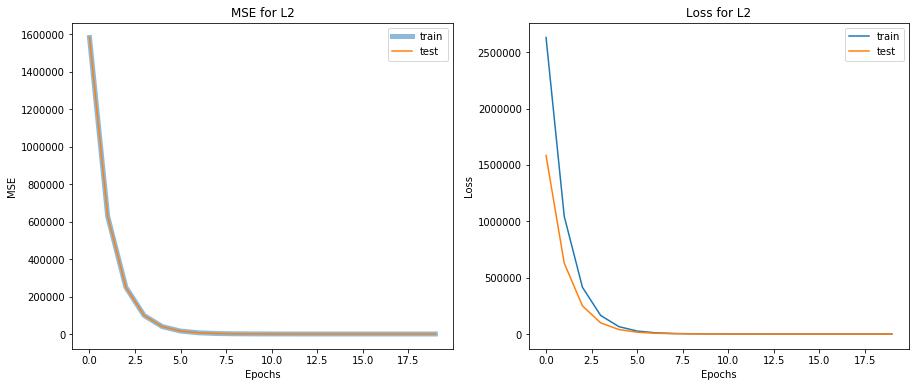

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figheight(6)
f.set_figwidth(15)
_ = ax1.plot(np.arange(len(epoch_mse_list)), epoch_mse_list, alpha = 0.5, linewidth = 5)
_ = ax1.plot(np.arange(len(test_epoch_mse_list)), test_epoch_mse_list)
_ = ax1.legend(['train', 'test'])
_ = ax1.set_title("MSE for L2")
_ = ax1.set_xlabel("Epochs")
_ = ax1.set_ylabel("MSE")

_ = ax2.plot(np.arange(len(loss_list)), loss_list)
_ = ax2.plot(np.arange(len(loss_list)), test_loss_list)
_ = ax2.legend(['train', 'test'])
_ = ax2.set_title("Loss for L2")
_ = ax2.set_xlabel("Epochs")
_ = ax2.set_ylabel("Loss")

In [23]:
print("MSE from gredient descent is:", musicMSE(test_prediction, testYears))

MSE from gredient descent is: 91.08899692045476


In [24]:
# Running pseudoinverse from sklearn package to compare
from sklearn.linear_model import Ridge as ridge_demo
ridge_pseudo = ridge_demo(solver = 'svd', alpha = 1)
ridge_pseudo.fit(trainFeat_norm, trainYears)
pred_outcome_ridge = ridge_pseudo.predict(testFeat_norm)
print("MSE from pseudoinverse is:", musicMSE(pred_outcome_ridge, testYears))

MSE from pseudoinverse is: 90.54738432337162


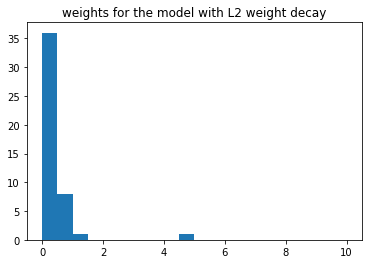

In [25]:
_ = plt.hist(weights, bins = 20, range = (0, 10))
_ = plt.title("weights for the model with L2 weight decay")

## Part 3 - L1 Weight Decay

In [26]:
# Loss Function
def cal_loss_l1(weights, data, pred, true_labels, alpha):
    # With L2 regularization
    data = np.stack(data, axis = 0)
    loss = musicMSE(pred, true_labels) + alpha * np.sqrt(np.dot(weights.T, weights)) / len(data) / 2
    loss_grad = (np.dot(data.T, (pred - true_labels)) + alpha * (weights/np.sqrt(np.dot(weights.T, weights)))) / len(data)
    return loss, loss_grad

In [27]:
# Function to do stochastic gradient descent with mini-batches
def single_stochastic_gradient_l1(train_data, train_labels, test_data, test_labels, weights, mini_batch_size, learning_rate, alpha):
    train_zip = list(zip(train_data, train_labels))
    shuffle(train_zip)
    train_data_shuff, train_labels_shuff = zip(*train_zip)
    
    test_zip = list(zip(test_data, test_labels))
    shuffle(test_zip)
    test_data_shuff, test_labels_shuff = zip(*test_zip)
    
    iter_num = len(train_data)//mini_batch_size
    prev_grad = 0
    
    loss = 0

    for i in range(iter_num):
        new_p = forward(train_data_shuff[i * mini_batch_size:(i + 1) * mini_batch_size], weights)
        new_loss, loss_grad = cal_loss_l1(weights, train_data_shuff[i * mini_batch_size:(i + 1) * mini_batch_size],
                                   new_p, train_labels_shuff[i * mini_batch_size:(i + 1) * mini_batch_size], alpha)
        loss = loss + new_loss
        # Find new weights
        weights = weights - learning_rate * loss_grad
        
    # For training data
    new_pred = forward(train_data_shuff, weights)
    epoch_mse = musicMSE(new_pred, train_labels_shuff)
    # For testing data
    test_new_pred = forward(test_data_shuff, weights)
    test_loss, _ = cal_loss_l1(weights, test_data_shuff, test_new_pred, test_labels_shuff, alpha)
    test_epoch_mse = musicMSE(test_new_pred, test_labels_shuff)
    return epoch_mse, test_epoch_mse, weights, loss/iter_num, test_loss

In [28]:
# Adjusting the hyperparam manually
# (Mini-batch size, learning rate, alpha)
param_l1 = (10000, 0.01, 1)
l1_epoch_mse_list, l1_test_epoch_mse_list, l1_weights, l1_loss_list, l1_test_loss_list, l1_test_prediction = main_music((trainYears, trainFeat_norm), (testYears, testFeat_norm), param_l1, 20, "L1")

5 epochs --- training mse: 39300.0
10 epochs --- training mse: 478.0
15 epochs --- training mse: 96.0
20 epochs --- training mse: 92.0


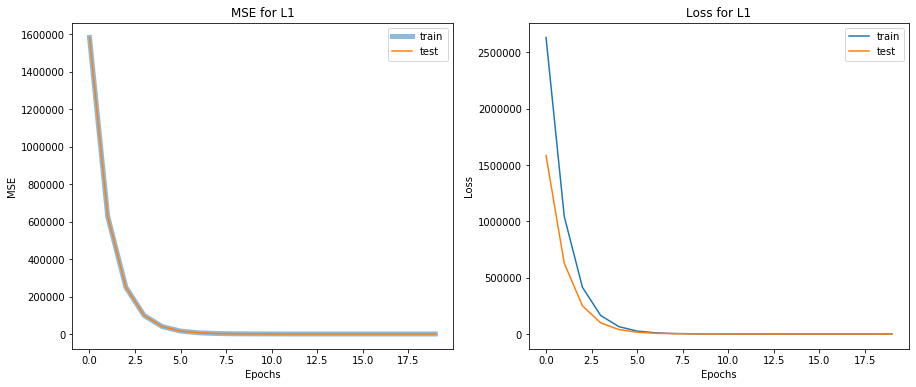

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figheight(6)
f.set_figwidth(15)
_ = ax1.plot(np.arange(len(l1_epoch_mse_list)), l1_epoch_mse_list, alpha = 0.5, linewidth = 5)
_ = ax1.plot(np.arange(len(l1_test_epoch_mse_list)), l1_test_epoch_mse_list)
_ = ax1.legend(['train', 'test'])
_ = ax1.set_title("MSE for L1")
_ = ax1.set_xlabel("Epochs")
_ = ax1.set_ylabel("MSE")

_ = ax2.plot(np.arange(len(l1_loss_list)), l1_loss_list)
_ = ax2.plot(np.arange(len(l1_loss_list)), l1_test_loss_list)
_ = ax2.legend(['train', 'test'])
_ = ax2.set_title("Loss for L1")
_ = ax2.set_xlabel("Epochs")
_ = ax2.set_ylabel("Loss")

In [30]:
print("MSE from gredient descent is:", musicMSE(l1_test_prediction, testYears))

MSE from gredient descent is: 90.99539036625283


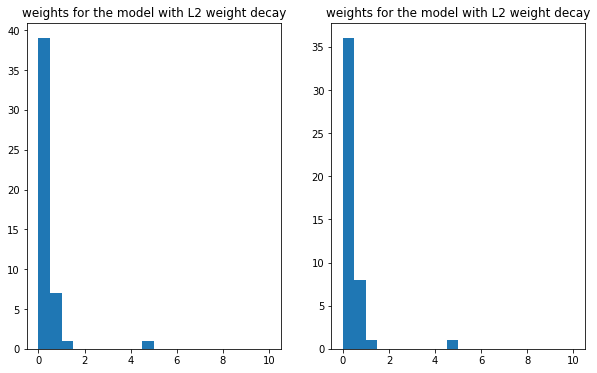

In [31]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figheight(6)
f.set_figwidth(10)
_ = ax1.hist(l1_weights, bins = 20, range = (0, 10))
_ = ax1.set_title("weights for the model with L2 weight decay")

_ = ax2.hist(weights, bins = 20, range = (0, 10))
_ = ax2.set_title("weights for the model with L2 weight decay")

## Part 4 - Poisson (Count) Regression

In [32]:
# Forward pass function
def forward_log_poisson(x, weight):
    return np.dot(np.array(x), np.array(weight))

In [33]:
def prediction_poisson(pred):
    return np.exp(pred)

In [34]:
# Loss Function
def cal_loss_poisson(weights, data, true_labels):
    # With poisson
    data = np.stack(data, axis = 0)
    log_loss = np.sum(np.dot(np.array(data), np.array(weights)) - np.log(true_labels) * np.log(np.dot(np.array(data), np.array(weights))))/len(true_labels)
    log_loss_grad = (np.dot(data.T, (np.dot(np.array(data), np.array(weights)) - true_labels)))
    return log_loss, log_loss_grad

In [37]:
# Function to do stochastic gradient descent with mini-batches
def single_stochastic_gradient_poisson(train_data, train_labels, test_data, test_labels, weights, mini_batch_size, learning_rate):
    train_zip = list(zip(train_data, train_labels))
    shuffle(train_zip)
    train_data_shuff, train_labels_shuff = zip(*train_zip)
    
    test_zip = list(zip(test_data, test_labels))
    shuffle(test_zip)
    test_data_shuff, test_labels_shuff = zip(*test_zip)
    train_labels_shuff_log = np.log(train_labels_shuff)
    test_labels_shuff_log = np.log(test_data_shuff)
    
    iter_num = len(train_data)//mini_batch_size
    
    for i in range(iter_num):
        new_loss, loss_grad = cal_loss_poisson(weights, train_data_shuff[i * mini_batch_size:(i + 1) * mini_batch_size],
                                               train_labels_shuff_log[i * mini_batch_size:(i + 1) * mini_batch_size])
        # Find new weights
        weights = weights - learning_rate * loss_grad
        
    # For training data
    new_pred = prediction_poisson(forward_log_poisson(train_data_shuff, weights))
    epoch_mse = musicMSE(new_pred, train_labels_shuff)
    loss, _ = cal_loss_poisson(weights, train_data_shuff, train_labels_shuff)
    # For testing data
    test_new_pred = prediction_poisson(forward_log_poisson(test_data_shuff, weights))
    test_loss, _ = cal_loss_poisson(weights, test_data_shuff, test_labels_shuff)
    test_epoch_mse = musicMSE(test_new_pred, test_labels_shuff)
    return epoch_mse, test_epoch_mse, weights, loss, test_loss

In [38]:
# Adjusting the hyperparam manually
# (Mini-batch size, learning rate, No alpha = 0)
param_p = (1000, 0.00001, 0)
poisson_epoch_mse_list, poisson_test_epoch_mse_list, poisson_weights, poisson_loss_list, poisson_test_loss_list, poisson_test_prediction = main_music((trainYears, trainFeat_norm), (testYears, testFeat_norm), param_p, 5, "P")

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
C:\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


5 epochs --- training mse: 92.0


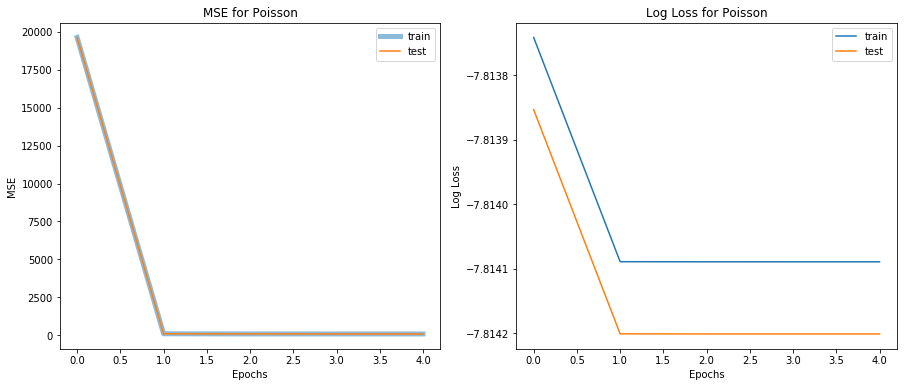

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figheight(6)
f.set_figwidth(15)
_ = ax1.plot(np.arange(len(poisson_epoch_mse_list)), poisson_epoch_mse_list, alpha = 0.5, linewidth = 5)
_ = ax1.plot(np.arange(len(poisson_test_epoch_mse_list)), poisson_test_epoch_mse_list)
_ = ax1.legend(['train', 'test'])
_ = ax1.set_title("MSE for Poisson")
_ = ax1.set_xlabel("Epochs")
_ = ax1.set_ylabel("MSE")

_ = ax2.plot(np.arange(len(poisson_loss_list)), poisson_loss_list)
_ = ax2.plot(np.arange(len(poisson_loss_list)), poisson_test_loss_list)
_ = ax2.legend(['train', 'test'])
_ = ax2.set_title("Log Loss for Poisson")
_ = ax2.set_xlabel("Epochs")
_ = ax2.set_ylabel("Log Loss")

In [40]:
print("MSE from gredient descent is:", musicMSE(poisson_test_prediction, testYears))

MSE from gredient descent is: 90.6880556254963


## Part 5 - Classification

In [41]:
# One-hot function to make the labels into one-hot vector
def years_one_hot(labels):
    one_hot_labels = np.zeros((len(labels), 89))
    for i in range(len(labels)):
        one_hot_labels[i][int(labels[i]) - 1923] = 1
    return one_hot_labels

In [42]:
# Softmax function
def softmax(output_list):
    exp_output_list = np.exp(output_list - np.max(output_list))
    return exp_output_list/(np.sum(exp_output_list, keepdims = True))

In [61]:
# Cross-entropy loss Function
def cross_entropy(data, pred, true_labels, weights, l2_weight_decay_factor):
    # With L2 regularization
    data = np.stack(data, axis = 0)
    loss = - np.sum((np.array(true_labels) * np.log(pred)))/len(true_labels) + l2_weight_decay_factor * np.linalg.norm(weights, 2)/2
    loss_grad = pred.copy()
    loss_grad = loss_grad - true_labels
    loss_grad = np.dot(data.T, loss_grad)
    loss_grad = loss_grad/len(true_labels)
    return loss, loss_grad

In [62]:
# Function to do stochastic gradient descent with mini-batches
def single_stochastic_gradient_softmax(train_data, train_labels, test_data, test_labels, weights, mini_batch_size, learning_rate, momentum_rate, l2_weight_decay_factor):
    train_zip = list(zip(train_data, train_labels))
    shuffle(train_zip)
    train_data_shuff, train_labels_shuff = zip(*train_zip)
    train_labels_shuff_c = years_one_hot(train_labels_shuff)
    
    test_zip = list(zip(test_data, test_labels))
    shuffle(test_zip)
    test_data_shuff, test_labels_shuff = zip(*test_zip)
    test_labels_shuff_c = years_one_hot(test_labels_shuff)
    
    iter_num = len(train_data)//mini_batch_size
    prev_grad = 0
    loss = 0
    for i in range(iter_num):
        
        new_pred = forward(train_data_shuff[i * mini_batch_size:(i + 1) * mini_batch_size], weights)
        new_p = softmax(new_pred)
        new_loss, new_loss_grad = cross_entropy(train_data_shuff[i * mini_batch_size:(i + 1) * mini_batch_size], new_p, train_labels_shuff_c[i * mini_batch_size:(i + 1) * mini_batch_size], weights, l2_weight_decay_factor)
        loss = loss + new_loss
        # Find new weights
        weights = weights - momentum_rate * prev_grad - learning_rate * new_loss_grad
        prev_grad = new_loss_grad
        
    # For training data
    new_pred = forward(train_data_shuff, weights)
    new_p = softmax(new_pred)
    new_p = new_p.argmax(1) + 1923
    epoch_mse = musicMSE(new_p, train_labels_shuff)

    # For testing data
    test_new_pred = forward(test_data_shuff, weights)
    test_new_p = softmax(test_new_pred)
    test_loss, _ = cross_entropy(test_data_shuff, test_new_p, test_labels_shuff_c, weights, l2_weight_decay_factor)
    test_new_p = test_new_p.argmax(1) + 1923
    test_epoch_mse = musicMSE(test_new_p, test_labels_shuff)
    
    return epoch_mse, test_epoch_mse, weights, loss/iter_num, test_loss

In [63]:
# Returns the learned weights, the mean per class accuracy for each epoch for train and test,
# loss for each epoch for train and test
def train_softmax(train_data, train_labels, test_data, test_labels, weights, mini_batch_size, learning_rate, momentum_rate, l2_weight_decay_factor, num_epochs):
    epoch_acc_list = []
    test_epoch_acc_list = []
    loss_list = []
    test_loss_list = []
    
    early_stop_count = 0
    for i in range(num_epochs):
        epoch_acc, test_epoch_acc, weights, loss, test_loss = single_stochastic_gradient_softmax(train_data, train_labels, test_data, test_labels, weights, mini_batch_size, learning_rate, momentum_rate, l2_weight_decay_factor)
        epoch_acc_list.append(epoch_acc)
        test_epoch_acc_list.append(test_epoch_acc)
        loss_list.append(loss)
        test_loss_list.append(test_loss)
        print(i + 1, "epochs --- training mse:", round(epoch_acc, 6))

    return epoch_acc_list, test_epoch_acc_list, weights, loss_list, test_loss_list

In [64]:
# Function to create the single layer neural network for softmax classifier
def main_music_softmax(train_zip, test_zip, param, num_epochs = 1000):
    # param = (Mini-batch size, learning rate, momentum rate, and L2 weight decay factor)
    mini_batch_size, learning_rate, momentum_rate, l2_weight_decay_factor = param
    
    train_labels, train_data = train_zip
    test_labels, test_data = test_zip
    
    # Initialize random weights
    weights = np.random.random((91, 89))
    
    epoch_mse_list, test_epoch_mse_list, weights, loss_list, test_loss_list = train_softmax(train_data, train_labels, test_data, test_labels, weights, mini_batch_size, learning_rate, momentum_rate, l2_weight_decay_factor, num_epochs)

    test_pred = forward(test_data, weights)
    test_p = softmax(test_pred)
    test_prediction = test_p.argmax(1) + 1922
       
    return epoch_mse_list, test_epoch_mse_list, weights, loss_list, test_loss_list, test_prediction

In [65]:
# Adjusting the hyperparam manually
# (Mini-batch size, learning rate, momentum rate, and L2 weight decay factor)
param = (1000, 0.05, 0.01, 0.1)
softmax_epoch_mse_list, softmax_test_epoch_mse_list, softmax_weights, softmax_loss_list, softmax_test_loss_list, softmax_test_prediction = main_music_softmax((trainYears, trainFeat_norm), (testYears, testFeat_norm), param, 10)

1 epochs --- training mse: 794.543523
2 epochs --- training mse: 375.795439
3 epochs --- training mse: 231.708366
4 epochs --- training mse: 178.895009
5 epochs --- training mse: 159.905424
6 epochs --- training mse: 152.453148
7 epochs --- training mse: 149.48013
8 epochs --- training mse: 148.012156
9 epochs --- training mse: 147.413714
10 epochs --- training mse: 146.994277


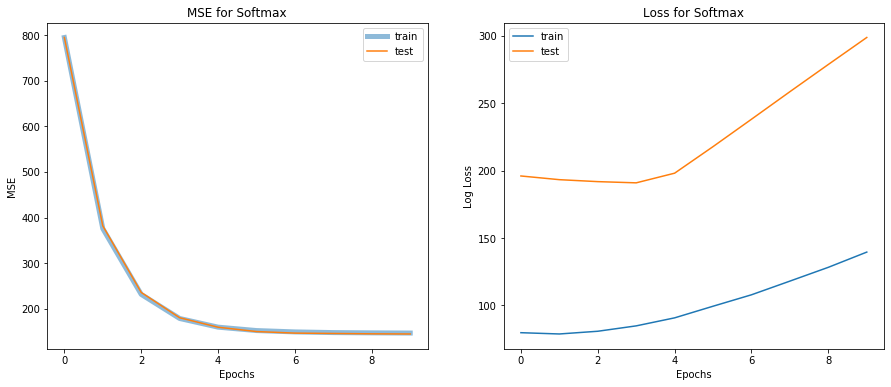

In [66]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figheight(6)
f.set_figwidth(15)
_ = ax1.plot(np.arange(len(softmax_epoch_mse_list)), softmax_epoch_mse_list, alpha = 0.5, linewidth = 5)
_ = ax1.plot(np.arange(len(softmax_test_epoch_mse_list)), softmax_test_epoch_mse_list)
_ = ax1.legend(['train', 'test'])
_ = ax1.set_title("MSE for Softmax")
_ = ax1.set_xlabel("Epochs")
_ = ax1.set_ylabel("MSE")

_ = ax2.plot(np.arange(len(softmax_loss_list)), softmax_loss_list)
_ = ax2.plot(np.arange(len(softmax_loss_list)), softmax_test_loss_list)
_ = ax2.legend(['train', 'test'])
_ = ax2.set_title("Loss for Softmax")
_ = ax2.set_xlabel("Epochs")
_ = ax2.set_ylabel("Log Loss")

In [58]:
print("MSE from gredient descent is:", musicMSE(softmax_test_prediction, testYears))

MSE from gredient descent is: 135.1878522593016


## Part 6 - Model Comparison

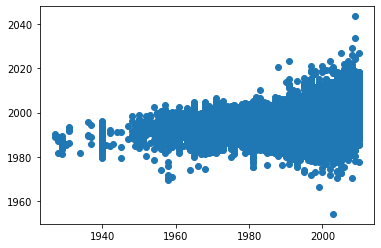

In [72]:
plt.scatter(testYears, l1_test_prediction)

In [141]:
def find_each_year_mse(y, pred):
    pred_list = []
    for i in range(1927, 2011):
        which = np.where(y == i)[0]
        if which.tolist() == []:
            pred_list.append(-10000)
        else:
            pred_list.append(musicMSE(y[np.where(y == i)[0]], pred[np.where(testYears == i)[0]]))
    return pred_list

In [148]:
l2_compare = find_each_year_mse(testYears, test_prediction)
l1_compare = find_each_year_mse(testYears, l1_test_prediction)
poisson_compare = find_each_year_mse(testYears, poisson_test_prediction)
softmax_compare = find_each_year_mse(testYears, softmax_test_prediction)

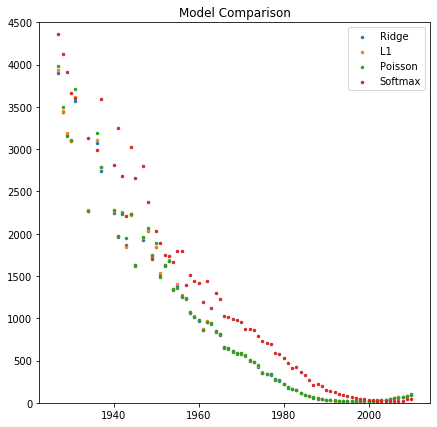

In [162]:
plt.figure(figsize=(7, 7))
plt.scatter(np.arange(1927, 2011), l2_compare, s = 6)
plt.scatter(np.arange(1927, 2011), l1_compare, s = 6)
plt.scatter(np.arange(1927, 2011), poisson_compare, s = 6)
plt.scatter(np.arange(1927, 2011), softmax_compare, s = 6)
plt.ylim(0, 4500)
plt.legend(["Ridge", "L1", "Poisson", "Softmax"])
_ = plt.title("Model Comparison")

In [163]:
weights

array([ 4.83562293e+00, -2.33744582e+00, -1.27925514e+00, -7.26932985e-01,
       -1.78521861e-01, -2.18650542e+00,  3.77982395e-01, -6.28958991e-01,
       -4.73423008e-01,  1.70762445e-01,  4.43062993e-02, -3.42792481e-01,
        8.77751719e-01,  5.50506297e-01, -6.35532328e-01,  8.96265529e-01,
        2.73924809e-01,  6.66651101e-01,  6.60808524e-01,  8.07830605e-01,
        3.64493810e-02,  1.18238814e-01,  1.03520018e+00,  3.99400505e-01,
       -2.74301934e-01,  1.81841604e-02,  7.16630904e-01,  9.35959108e-02,
        1.56899443e-01,  2.12723316e-02, -1.43120336e-01, -1.21035171e-01,
       -3.31517905e-01,  1.42858123e-01,  1.65972965e-02, -4.82720768e-01,
       -3.26961806e-02,  3.37204191e-01,  4.87814627e-01, -3.08699779e-01,
       -3.40445811e-01, -8.81554626e-02, -1.43312950e-01, -5.29835128e-02,
       -1.45944915e-01,  2.78498644e-01,  2.56438477e-01, -3.94960246e-01,
        5.51146378e-03,  2.31714740e-01,  6.96221755e-02, -1.07990188e-01,
        8.87501151e-02, -

In [164]:
l1_weights

array([ 4.77730409e+00, -2.31610984e+00, -1.26697596e+00, -6.91194907e-01,
       -1.82387157e-01, -2.23582379e+00,  3.67057010e-01, -6.41325156e-01,
       -4.48443930e-01,  1.13148080e-01,  2.38573844e-02, -3.36018196e-01,
        8.98140556e-01,  5.51380020e-01, -5.86948741e-01,  8.48850407e-01,
        2.94704856e-01,  4.54135954e-01,  6.11130084e-01,  8.19588302e-01,
        2.30944727e-01,  1.46260424e-01,  1.22920890e+00,  2.55832195e-01,
       -2.67749182e-01,  3.11480067e-02,  7.22838140e-01,  6.83307212e-02,
        2.14896158e-01,  4.49325308e-02, -9.98338161e-02, -9.04433995e-02,
       -4.18501653e-01,  1.73608302e-01,  7.49786040e-02, -5.06442287e-01,
       -6.83864302e-02,  3.16396847e-01,  4.88040614e-01, -2.87098715e-01,
       -3.20626255e-01, -8.78474154e-02, -1.09825306e-01, -5.58253253e-02,
       -1.88765199e-01,  2.29263709e-01,  2.62927249e-01, -4.31448532e-01,
       -7.40327216e-03,  2.18478672e-01,  5.60313993e-02, -7.71575789e-02,
        9.36261008e-02, -

In [165]:
poisson_weights

array([ 2.61886581e-03, -1.41532240e-03, -8.01993573e-04, -2.02436384e-06,
       -1.84658240e-04, -1.41445367e-03, -2.52245998e-05, -3.02541719e-04,
       -2.80538657e-04, -8.94737359e-06, -2.44452083e-04, -7.09070330e-05,
        5.77008591e-04,  2.52718143e-04, -3.25525781e-04,  3.53993536e-04,
        7.85443041e-05,  3.25500109e-04,  3.81999618e-04, -4.54206581e-05,
        2.06624443e-04,  2.13645059e-04,  8.87705539e-04,  1.83961878e-04,
       -1.96609483e-04,  1.18605304e-05,  4.72184901e-04,  3.93695722e-05,
        6.99971650e-05,  1.32177068e-05, -9.85101919e-05, -1.93033533e-05,
       -3.52411040e-04, -2.06708769e-05,  2.60183820e-05, -2.60250107e-04,
       -1.75160263e-05,  1.58028867e-04,  2.15308874e-04, -1.50686610e-04,
       -1.45793346e-04, -6.60300396e-05, -3.50241909e-05, -3.76008741e-05,
       -5.28626595e-05,  1.27411403e-04,  1.00547029e-04, -2.56141445e-04,
        1.51500440e-05,  1.22490136e-04, -3.29748795e-07, -5.83043601e-05,
        4.54586759e-05, -

In [166]:
softmax_weights

array([[ 2.64168901e-01,  2.22185805e-02,  8.07157406e-01, ...,
         5.38555253e+00,  2.36382932e+00,  1.09928859e-01],
       [ 2.87099667e-01,  6.82861181e-01,  7.07272694e-01, ...,
        -8.56961775e-02, -1.97792763e-01,  5.88946116e-01],
       [ 2.95294619e-01,  2.45250606e-01,  9.07779864e-01, ...,
        -5.65006872e-01,  1.26449586e-01,  6.03237294e-01],
       ...,
       [ 9.48365145e-01,  7.49756717e-03,  2.66240242e-01, ...,
         9.84362870e-01,  2.23533463e-01,  9.18140047e-01],
       [ 7.23993513e-01,  9.23765736e-01,  1.58477395e-01, ...,
         1.35869929e-01,  3.53476347e-01, -6.78956175e-04],
       [ 3.33406298e-01,  2.04664255e-01,  8.87929341e-02, ...,
         1.76071862e+01,  5.66217703e+00,  2.44386046e-01]])